

## Convolutional Neural Networks

---

In this notebook, we train a CNN on augmented images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database

In [17]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### 2. Visualize the First 24 Training Images

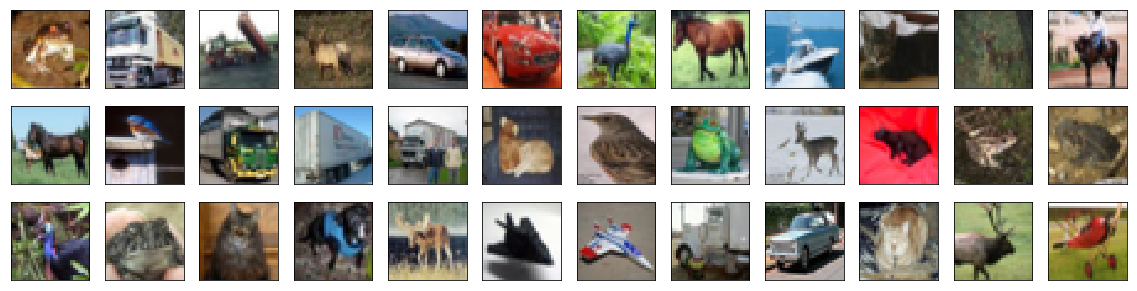

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [19]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [20]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

('x_train shape:', (45000, 32, 32, 3))
(45000, 'train samples')
(10000, 'test samples')
(5000, 'validation samples')


### 5. Create and Configure Augmented Image Generator

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

### 6. Visualize Original and Augmented Images

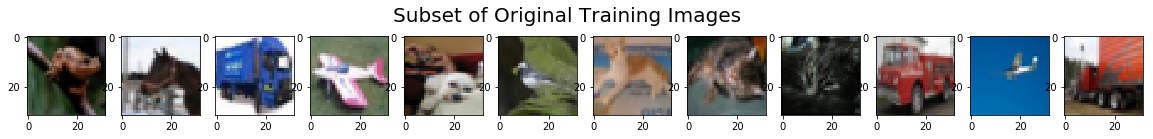

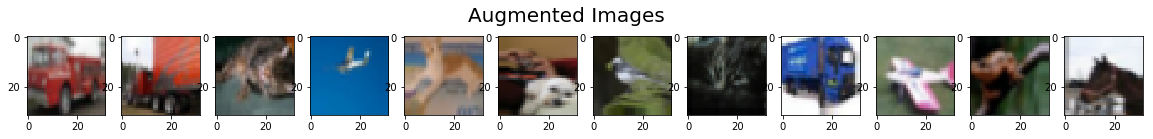

In [22]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)         

### 8. Compile the Model 

In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 9. Train the Model 

In [25]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/100
 - 30s - loss: 1.6566 - accuracy: 0.3952 - val_loss: 1.5556 - val_accuracy: 0.4866

Epoch 00001: val_loss improved from inf to 1.55560, saving model to aug_model.weights.best.hdf5
Epoch 2/100
 - 33s - loss: 1.3877 - accuracy: 0.5007 - val_loss: 1.2091 - val_accuracy: 0.5598

Epoch 00002: val_loss improved from 1.55560 to 1.20914, saving model to aug_model.weights.best.hdf5
Epoch 3/100
 - 29s - loss: 1.2744 - accuracy: 0.5465 - val_loss: 1.1496 - val_accuracy: 0.5640

Epoch 00003: val_loss improved from 1.20914 to 1.14962, saving model to aug_model.weights.best.hdf5
Epoch 4/100
 - 30s - loss: 1.2105 - accuracy: 0.5719 - val_loss: 1.2121 - val_accuracy: 0.6226

Epoch 00004: val_loss did not improve from 1.14962
Epoch 5/100
 - 32s - loss: 1.1799 - accuracy: 0.5847 - val_loss: 1.5049 - val_accuracy: 0.6381

Epoch 00005: val_loss did not improve from 1.14962
Epoch 6/100
 - 32s - loss: 1.1674 - accuracy: 0.5920 - val_loss: 1.1641 - val_accuracy: 0.6375

Epoch 00006: val_loss did 


Epoch 00054: val_loss did not improve from 0.71527
Epoch 55/100
 - 36s - loss: 1.6474 - accuracy: 0.4287 - val_loss: 1.8101 - val_accuracy: 0.4716

Epoch 00055: val_loss did not improve from 0.71527
Epoch 56/100
 - 34s - loss: 1.6737 - accuracy: 0.4260 - val_loss: 1.0562 - val_accuracy: 0.4968

Epoch 00056: val_loss did not improve from 0.71527
Epoch 57/100
 - 32s - loss: 1.6692 - accuracy: 0.4228 - val_loss: 1.6330 - val_accuracy: 0.4714

Epoch 00057: val_loss did not improve from 0.71527
Epoch 58/100
 - 33s - loss: 1.6815 - accuracy: 0.4170 - val_loss: 1.4801 - val_accuracy: 0.5163

Epoch 00058: val_loss did not improve from 0.71527
Epoch 59/100
 - 35s - loss: 1.6808 - accuracy: 0.4190 - val_loss: 1.1729 - val_accuracy: 0.5133

Epoch 00059: val_loss did not improve from 0.71527
Epoch 60/100
 - 32s - loss: 1.6801 - accuracy: 0.4157 - val_loss: 1.5583 - val_accuracy: 0.4849

Epoch 00060: val_loss did not improve from 0.71527
Epoch 61/100
 - 32s - loss: 1.7077 - accuracy: 0.4078 - val_

### 10. Load the Model with the Best Validation Accuracy

In [31]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

In [32]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

('\n', 'Test accuracy:', 0.6168000102043152)


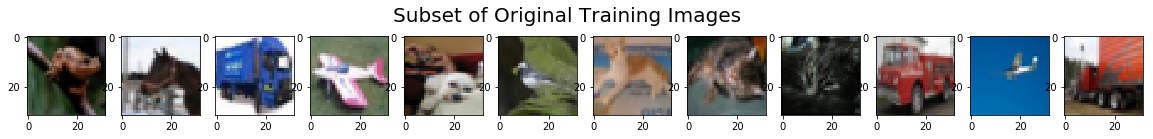

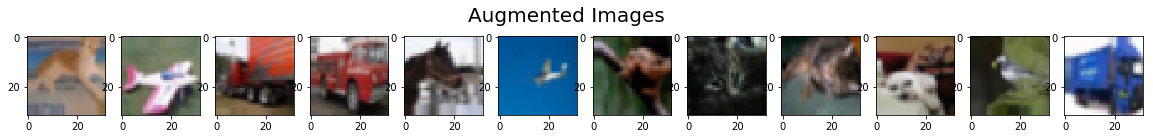

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)         


Epoch 00043: val_loss did not improve from 0.81553
Epoch 44/100
 - 36s - loss: 1.5484 - accuracy: 0.4724 - val_loss: 1.6535 - val_accuracy: 0.5294

Epoch 00044: val_loss did not improve from 0.81553
Epoch 45/100
 - 44s - loss: 1.5600 - accuracy: 0.4678 - val_loss: 2.2280 - val_accuracy: 0.4992

Epoch 00045: val_loss did not improve from 0.81553
Epoch 46/100
 - 33s - loss: 1.5646 - accuracy: 0.4666 - val_loss: 1.4569 - val_accuracy: 0.5165

Epoch 00046: val_loss did not improve from 0.81553
Epoch 47/100
 - 31s - loss: 1.5715 - accuracy: 0.4617 - val_loss: 1.2575 - val_accuracy: 0.5083

Epoch 00047: val_loss did not improve from 0.81553
Epoch 48/100
 - 40s - loss: 1.5660 - accuracy: 0.4602 - val_loss: 1.5795 - val_accuracy: 0.5378

Epoch 00048: val_loss did not improve from 0.81553
Epoch 49/100
 - 34s - loss: 1.5770 - accuracy: 0.4585 - val_loss: 1.2170 - val_accuracy: 0.5441

Epoch 00049: val_loss did not improve from 0.81553
Epoch 50/100
 - 35s - loss: 1.5894 - accuracy: 0.4597 - val_

 - 38s - loss: 1.8717 - accuracy: 0.3129 - val_loss: 1.5722 - val_accuracy: 0.3714

Epoch 00099: val_loss did not improve from 0.81553
Epoch 100/100
 - 36s - loss: 1.8781 - accuracy: 0.3070 - val_loss: 1.7596 - val_accuracy: 0.3718

Epoch 00100: val_loss did not improve from 0.81553
('\n', 'Test accuracy:', 0.5776000022888184)


In [33]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;
    
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

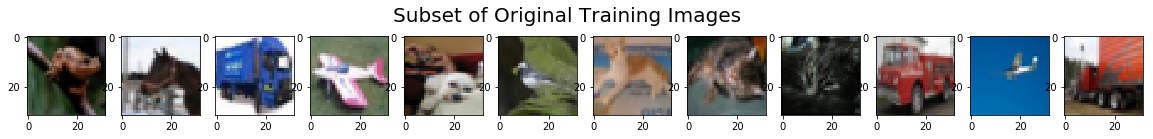

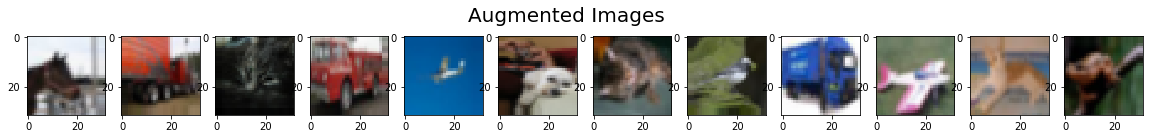

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 64)         


Epoch 00042: val_loss did not improve from 0.77182
Epoch 43/100
 - 27s - loss: 1.6020 - accuracy: 0.4500 - val_loss: 1.5871 - val_accuracy: 0.5109

Epoch 00043: val_loss did not improve from 0.77182
Epoch 44/100
 - 28s - loss: 1.6073 - accuracy: 0.4442 - val_loss: 1.1237 - val_accuracy: 0.5537

Epoch 00044: val_loss did not improve from 0.77182
Epoch 45/100
 - 27s - loss: 1.6285 - accuracy: 0.4376 - val_loss: 1.5144 - val_accuracy: 0.4825

Epoch 00045: val_loss did not improve from 0.77182
Epoch 46/100
 - 27s - loss: 1.6301 - accuracy: 0.4345 - val_loss: 1.4873 - val_accuracy: 0.5004

Epoch 00046: val_loss did not improve from 0.77182
Epoch 47/100
 - 27s - loss: 1.6152 - accuracy: 0.4396 - val_loss: 1.5614 - val_accuracy: 0.4527

Epoch 00047: val_loss did not improve from 0.77182
Epoch 48/100
 - 27s - loss: 1.6347 - accuracy: 0.4288 - val_loss: 1.4681 - val_accuracy: 0.4815

Epoch 00048: val_loss did not improve from 0.77182
Epoch 49/100
 - 27s - loss: 1.6267 - accuracy: 0.4336 - val_

 - 27s - loss: 1.6895 - accuracy: 0.3883 - val_loss: 1.3733 - val_accuracy: 0.4392

Epoch 00098: val_loss did not improve from 0.77182
Epoch 99/100
 - 27s - loss: 1.6801 - accuracy: 0.3892 - val_loss: 1.7249 - val_accuracy: 0.4485

Epoch 00099: val_loss did not improve from 0.77182
Epoch 100/100
 - 27s - loss: 1.6840 - accuracy: 0.3880 - val_loss: 1.4877 - val_accuracy: 0.4340

Epoch 00100: val_loss did not improve from 0.77182
('\n', 'Test accuracy:', 0.6381999850273132)


In [34]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;
    
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

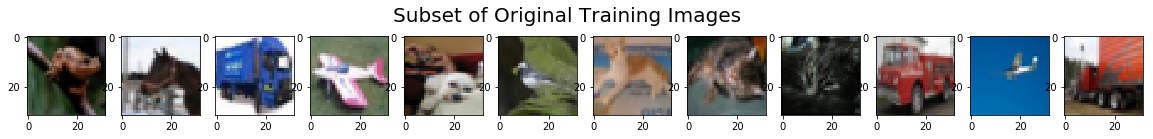

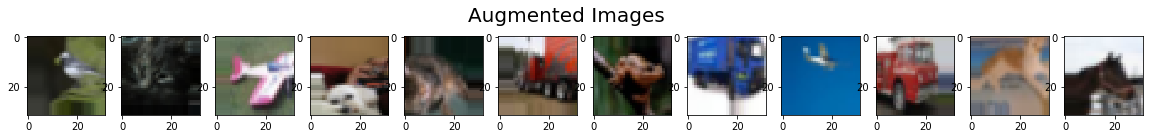

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 64)         


Epoch 00042: val_loss did not improve from 1.01638
Epoch 43/100
 - 27s - loss: 1.7226 - accuracy: 0.3935 - val_loss: 1.6556 - val_accuracy: 0.4016

Epoch 00043: val_loss did not improve from 1.01638
Epoch 44/100
 - 27s - loss: 1.7256 - accuracy: 0.3949 - val_loss: 1.7059 - val_accuracy: 0.3967

Epoch 00044: val_loss did not improve from 1.01638
Epoch 45/100
 - 27s - loss: 1.7360 - accuracy: 0.3862 - val_loss: 1.6929 - val_accuracy: 0.4626

Epoch 00045: val_loss did not improve from 1.01638
Epoch 46/100
 - 27s - loss: 1.7452 - accuracy: 0.3828 - val_loss: 1.4439 - val_accuracy: 0.4644

Epoch 00046: val_loss did not improve from 1.01638
Epoch 47/100
 - 28s - loss: 1.7560 - accuracy: 0.3800 - val_loss: 1.8374 - val_accuracy: 0.4807

Epoch 00047: val_loss did not improve from 1.01638
Epoch 48/100
 - 27s - loss: 1.7651 - accuracy: 0.3772 - val_loss: 1.7224 - val_accuracy: 0.4440

Epoch 00048: val_loss did not improve from 1.01638
Epoch 49/100
 - 28s - loss: 1.7713 - accuracy: 0.3739 - val_

 - 27s - loss: 1.8897 - accuracy: 0.3035 - val_loss: 1.4901 - val_accuracy: 0.3694

Epoch 00098: val_loss did not improve from 1.01638
Epoch 99/100
 - 27s - loss: 1.9058 - accuracy: 0.2974 - val_loss: 1.6333 - val_accuracy: 0.3559

Epoch 00099: val_loss did not improve from 1.01638
Epoch 100/100
 - 28s - loss: 1.8968 - accuracy: 0.3040 - val_loss: 1.8158 - val_accuracy: 0.3519

Epoch 00100: val_loss did not improve from 1.01638
('\n', 'Test accuracy:', 0.6080999970436096)


In [35]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;
    
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

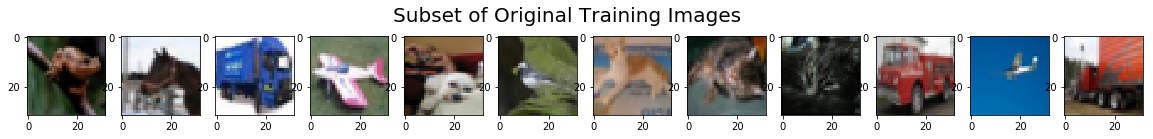

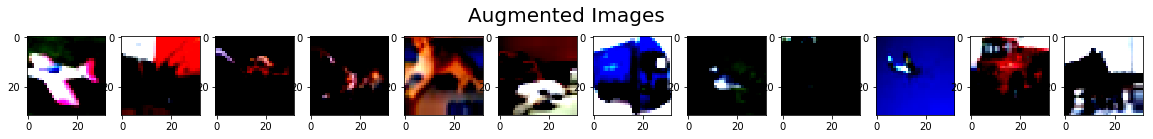

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 64)         

 - 28s - loss: 1.5900 - accuracy: 0.4563 - val_loss: 1.3286 - val_accuracy: 0.5131

Epoch 00043: val_loss did not improve from 0.84617
Epoch 44/100
 - 29s - loss: 1.6101 - accuracy: 0.4481 - val_loss: 1.3720 - val_accuracy: 0.4887

Epoch 00044: val_loss did not improve from 0.84617
Epoch 45/100
 - 28s - loss: 1.6170 - accuracy: 0.4448 - val_loss: 1.1800 - val_accuracy: 0.4913

Epoch 00045: val_loss did not improve from 0.84617
Epoch 46/100
 - 28s - loss: 1.6245 - accuracy: 0.4408 - val_loss: 1.2211 - val_accuracy: 0.5316

Epoch 00046: val_loss did not improve from 0.84617
Epoch 47/100
 - 29s - loss: 1.6261 - accuracy: 0.4418 - val_loss: 1.0399 - val_accuracy: 0.5195

Epoch 00047: val_loss did not improve from 0.84617
Epoch 48/100
 - 28s - loss: 1.6307 - accuracy: 0.4404 - val_loss: 1.3515 - val_accuracy: 0.4762

Epoch 00048: val_loss did not improve from 0.84617
Epoch 49/100
 - 29s - loss: 1.6500 - accuracy: 0.4340 - val_loss: 1.2271 - val_accuracy: 0.4692

Epoch 00049: val_loss did no


Epoch 00098: val_loss did not improve from 0.84617
Epoch 99/100
 - 28s - loss: 1.8513 - accuracy: 0.3088 - val_loss: 1.6729 - val_accuracy: 0.3221

Epoch 00099: val_loss did not improve from 0.84617
Epoch 100/100
 - 28s - loss: 1.8570 - accuracy: 0.3073 - val_loss: 1.6458 - val_accuracy: 0.3043

Epoch 00100: val_loss did not improve from 0.84617
('\n', 'Test accuracy:', 0.25600001215934753)


In [36]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
     featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
     featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;
    
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])